In [1]:
from base_rl.train import ParallelTrainer, OnlineTrainer
from base_rl.callbacks import SaveBestPolicy, SavePolicyOnTrainingEnd
import matplotlib.pyplot as plt
from q_learning.algorithm import QLearningAlgo, QLPolicy
from envs.env_creator import env_creator
from base_rl.eval_policy import EvalDiscreteStatePolicy
from base_rl.scheduler import DecayingExpScheduler, LinearScheduler, DecayingExpContinuousScheduler
import random

In [2]:
plt.rcParams["figure.figsize"] = [20, 12]
fixed_digits = 6
experiment_id = 282129#random.randrange(111111, 999999, fixed_digits)


## Init Model and env

In [3]:
device = 'cuda'
steps_per_episode = 1000
#model_names = ['model_h_c', 'model_final_h', 'model_aeq']
model_names = [  'untrained_model_aeq']



alpha


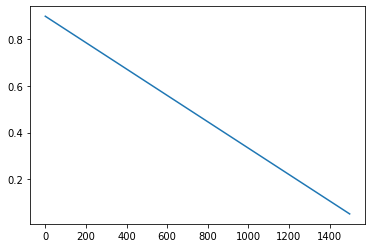

epsilon


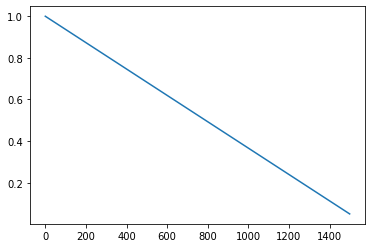

In [4]:

#alpha = DecayingExpContinuousScheduler(start=0.9, decay=0.999)

#epsilon = DecayingExpContinuousScheduler(start=0.8, decay=0.999)

gamma = 0.999
total_epochs = 6000
print('alpha')
alpha = LinearScheduler(start=0.9, end=0.05, total_steps=1500)
print('epsilon')
epsilon = LinearScheduler(start=1, end=0.05, total_steps=1500)

In [5]:

best_save_paths = []
last_save_paths = []
models_env_kwargs = []
for model_name in model_names:
    policy_path = f'tmp/q_learning/q_policy_{model_name}_{experiment_id}.pkl'
    env_kwargs = {'steps_per_episode': steps_per_episode, 'device': device,
                  'model_path': f'tmp/state_quantization/{model_name}'}
    best_save_paths.append(f'tmp/q_learning/q_policy_best_{model_name}_{experiment_id}.pkl')
    last_save_paths.append(f'tmp/q_learning/q_policy_{model_name}_{experiment_id}.pkl')
    models_env_kwargs.append(env_kwargs)



In [6]:

workers_kwargs = []
for i, model_name in enumerate(model_names):
    trainer_config = {
        'algo': QLearningAlgo(
            comment=f',id={experiment_id},model={model_name},gamma={gamma},total_epochs={total_epochs}',
            epochs=total_epochs, alpha=alpha, gamma=gamma, epsilon=epsilon, env_creator=env_creator,
            env_kwargs=models_env_kwargs[i], reward_offset=2000, show_reward_type='mean'
        ),
        'callbacks': [
            SaveBestPolicy(save_path=best_save_paths[i]),
            SavePolicyOnTrainingEnd(save_path=last_save_paths[i])
        ]
    }
    workers_kwargs.append(trainer_config)

parallel_trainer = ParallelTrainer(trainer_class=OnlineTrainer, workers_kwargs=workers_kwargs)
parallel_trainer.train()

/home/hamza/PycharmProjects/StateCompression/venv/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hamza/PycharmProjects/StateCompression/venv/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


## Evaluate best saves

Episode 24 Reward: -187.856581972358 || New State Found: False


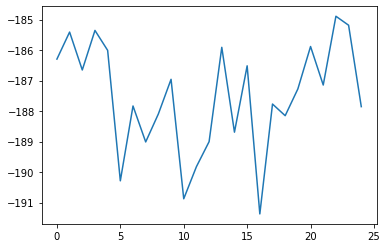

Reward Mean: -187.53195268342253
Reward std : 1.7737217345574423
tmp/state_quantization/model_aeq
Reward Mean: -187.53195268342253
Reward std : 1.7737217345574423


In [6]:
evaluators = []
for i, model_name in enumerate(model_names):
    eval_policy = QLPolicy.load(best_save_paths[i])
    evaluator = EvalDiscreteStatePolicy(policy=eval_policy, env_creator=env_creator, env_kwargs=models_env_kwargs[i])
    evaluator.evaluate(epochs=25)
    evaluators.append(evaluator)
for evaluator in evaluators:
    print(evaluator.env_kwargs['model_path'])
    print(f'Reward Mean: {evaluator.eval_mean}')
    print(f'Reward std : {evaluator.eval_std}')

In [7]:
plt.plot(evaluators[1].eval_trajectories[3]['actions'])

IndexError: list index out of range

In [ ]:
from envs.plot import plot_industrial_benchmark_trajectories

plot_industrial_benchmark_trajectories(evaluators[1].eval_trajectories[0]['info'])

## Evaluate last saves

Episode 24 Reward: -188.19564407992553 || New State Found: False


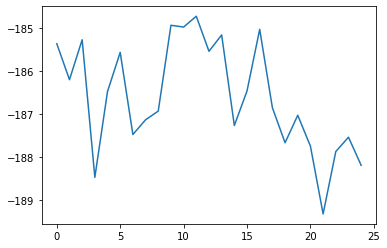

Reward Mean: -186.61190506215502
Reward std : 1.2551599789784427
tmp/state_quantization/model_aeq
Reward Mean: -186.61190506215502
Reward std : 1.2551599789784427


In [7]:
evaluators = []
for i, model_name in enumerate(model_names):
    eval_policy = QLPolicy.load(last_save_paths[i])
    evaluator = EvalDiscreteStatePolicy(policy=eval_policy, env_creator=env_creator, env_kwargs=models_env_kwargs[i])
    evaluator.evaluate(epochs=25)
    evaluators.append(evaluator)
for evaluator in evaluators:
    print(evaluator.env_kwargs['model_path'])
    print(f'Reward Mean: {evaluator.eval_mean}')
    print(f'Reward std : {evaluator.eval_std}')